In [81]:
from hedge_stand import HedgeST,HedgeSTBoll
from datetime import date, datetime
from demeter import TokenInfo, PoolBaseInfo, Actuator, Strategy, Asset, AccountStatus, BuyAction, SellAction, RowData, \
    ChainType
import optunity
import optunity.metrics
from decimal import Decimal
import pandas as pd
import  matplotlib.pylab as plt
# import logging 
# from logging import handlers
from load_data import pool_id_1_eth_u_500,pool_id_1_wbtc_u_3000

from strategy_ploter import  plot_position_return_decomposition

import quantstats as qs
qs.extend_pandas()

%matplotlib inline

def backtest_boll(a, hedge_spread_split,hedge_spread_rate,alpha,boll_period_n):
    # global RUNNING_TIME
    # print(f"==================spread running time {RUNNING_TIME}==================")

    decimal_a = Decimal(a).quantize(Decimal('0.00'))
    decimal_hedge_spread_split = Decimal(hedge_spread_split).quantize(Decimal('0.0'))
    decimal_hedge_spread_rate = Decimal(hedge_spread_rate).quantize(Decimal('0.00'))

    ema_max_spread_rate = round(0.2,4)



    #收益计算基础参数
    # net_value_base = 'ETH'

    runner_instance = Actuator(PAIR_POOL)
    # runner_instance.enable_notify = False
    runner_instance.strategy = HedgeSTBoll(a=decimal_a,hedge_spread_split = decimal_hedge_spread_split,hedge_spread_rate=decimal_hedge_spread_rate,alpha=alpha,ema_max_spread_rate=ema_max_spread_rate,period_n=int(boll_period_n))
    runner_instance.set_assets([Asset(USDC, 1000000)])
    save_path = f"../demeter/data/ETH/{POOL_ID}"
    runner_instance.data_path = save_path
    runner_instance.load_data(ChainType.Ethereum.name,
                                POOL_ID,
                                DATE_START,
                               DATE_END)
    runner_instance.run(enable_notify=False)

    hedge_count = runner_instance.strategy.hedge_count
    outside_ema_count = runner_instance.strategy.outside_ema_count

    # df_status = pd.DataFrame(runner_instance.account_status_list)

    total_net_value = runner_instance.final_status.net_value
    
    final_total_usdc_value = round(total_net_value + runner_instance.strategy.e.df['total'].iloc[-1],3)
    
    final_price = runner_instance.final_status.price

    final_total_eth_value = round(final_total_usdc_value / final_price,3)


    notice = f"ema+alpha:{RUNNING_TIME} times, a:{decimal_a}, hedge_spread_split:{decimal_hedge_spread_split}, hedge_spread_rate:{decimal_hedge_spread_rate},alpa:{alpha}"
    result =f" result: outside_ema_count:{outside_ema_count},hedge count:{hedge_count} final_total_eth_value:{final_total_eth_value},final_total_usdc_value:{final_total_usdc_value}"  
    print(notice)
    print(result)
    # if SEND_NOTICE:
    #     send_notice('CEX_Notify',notice)

    # RUNNING_TIME +=1

    # if NET_VALUE_BASE == 'USDC':
    #     print(final_total_usdc_value)
    #     return float(final_total_usdc_value)
    #     # profit_rate_usdc = profit_usdc / runner_instance.strategy.init_total_usdc
    # else:
    #     print(float(final_total_usdc_value / final_price))
    #     return float(final_total_usdc_value / final_price)


    return runner_instance


def backtest_instance(a, hedge_spread_split,hedge_spread_rate,alpha):
    # global RUNNING_TIME
    # print(f"==================spread running time {RUNNING_TIME}==================")

    decimal_a = Decimal(a).quantize(Decimal('0.00'))
    decimal_hedge_spread_split = Decimal(hedge_spread_split).quantize(Decimal('0.0'))
    decimal_hedge_spread_rate = Decimal(hedge_spread_rate).quantize(Decimal('0.00'))

    alpha = round(alpha,4)
    # ema_max_spread_rate = round(ema_max_spread_rate,4)

    eth = TokenInfo(name="eth", decimal=18)
    usdc = TokenInfo(name="usdc", decimal=6)
    pool = PoolBaseInfo(usdc, eth, 0.05, usdc)

    #收益计算基础参数
    # net_value_base = 'ETH'

    runner_instance = Actuator(pool)
    # runner_instance.enable_notify = False
    runner_instance.strategy = HedgeST(decimal_a,decimal_hedge_spread_split,decimal_hedge_spread_rate,alpha)
    runner_instance.set_assets([Asset(usdc, 1000000)])
    save_path = f"../demeter/data/ETH/{pool_id_1_eth_u_500}"
    runner_instance.data_path = save_path
    runner_instance.load_data(ChainType.Ethereum.name,
                                pool_id_1_eth_u_500,
                                DATE_START,
                               DATE_END)
    runner_instance.run(enable_notify=False)

    hedge_count = runner_instance.strategy.hedge_count
    outside_ema_count = runner_instance.strategy.outside_ema_count

    # df_status = pd.DataFrame(runner_instance.account_status_list)

    total_net_value = runner_instance.final_status.net_value
    
    final_total_usdc_value = round(total_net_value + runner_instance.strategy.e.df['total'].iloc[-1],3)
    
    final_price = runner_instance.final_status.price

    final_total_eth_value = round(final_total_usdc_value / final_price,3)

    #处理df_status
    df_status = pd.DataFrame(runner_instance.account_status_list)
    df_merge = pd.merge(e.df, df_status, on='timestamp', how='inner')

    df_merge['total_value'] = df_merge['total'] + df_merge['net_value']
    df_merge['total_value_eth'] = df_merge['total_value'] / df_merge['price']

    df_merge.set_index('timestamp', inplace=True)




    notice = f"ema+alpha:{RUNNING_TIME} times, a:{decimal_a}, hedge_spread_split:{decimal_hedge_spread_split}, hedge_spread_rate:{decimal_hedge_spread_rate},alpa:{alpha}"
    result =f" result: outside_ema_count:{outside_ema_count},hedge count:{hedge_count} final_total_eth_value:{final_total_eth_value},final_total_usdc_value:{final_total_usdc_value}"  
    print(notice)
    print(result)
    # if SEND_NOTICE:
    #     send_notice('CEX_Notify',notice)

    # RUNNING_TIME +=1

    # if NET_VALUE_BASE == 'USDC':
    #     print(final_total_usdc_value)
    #     return float(final_total_usdc_value)
    #     # profit_rate_usdc = profit_usdc / runner_instance.strategy.init_total_usdc
    # else:
    #     print(float(final_total_usdc_value / final_price))
    #     return float(final_total_usdc_value / final_price)


    return runner_instance





In [82]:

def generate_dfmerge(runner_instance):
    e = runner_instance.strategy.e

    total_net_value = runner_instance.final_status.net_value
        
    final_total_usdc_value = total_net_value + runner_instance.strategy.e.df['total'].iloc[-1]


    final_price = runner_instance.final_status.price
    # if net_value_base == 'USDC':
    profit_usdc = round(final_total_usdc_value- runner_instance.strategy.init_total_usdc,3)
    profit_rate_usdc = round(profit_usdc / runner_instance.strategy.init_total_usdc,3)
    # else:
    profit_eth = round(final_total_usdc_value/final_price - runner_instance.strategy.init_total_symbol,3)
    profit_rate_eth = round(profit_eth / runner_instance.strategy.init_total_symbol,3)

    print(f"USDC profit: {profit_usdc}, profit_rate: {profit_rate_usdc}")

    print(f"ETH profit: {profit_eth}, profit_rate: {profit_rate_eth}")

    df_status = pd.DataFrame(runner_instance.account_status_list)
    df_merge = pd.merge(e.df, df_status, on='timestamp', how='inner')

    df_merge['total_value'] = df_merge['total'] + df_merge['net_value']

    df_merge.set_index('timestamp', inplace=True)

    df_merge['total_value_profit_rate'] = df_merge['total_value'] / runner_instance.strategy.init_total_usdc


    df_merge['total_value_eth'] = df_merge['total_value'] / df_merge['price']

    df_merge['net_value_eth'] = df_merge['net_value'] / df_merge['price']

    df_merge['total_value_eth_profit_rate'] = df_merge['total_value_eth'] / runner_instance.strategy.init_total_symbol

    df_merge_f = df_merge.apply(pd.to_numeric, downcast='float')
   
    df_merge_f['net_value_rate'] = df_merge_f['net_value'] / df_merge_f['net_value'].iloc[0]

    df_merge_f['price_rate'] = df_merge_f['price'] / df_merge_f['price'].iloc[0]
    return df_merge_f

In [83]:
# pd.options.plotting.backend = "plotly"

CHAIN_ID = 'ETH'
NET_VALUE_BASE = 'WBTC'
RUNNING_TIME = 1
SEND_NOTICE = False
str_date_start = '2022-9-1'
str_date_end = '2022-11-30'
POOL_ID = pool_id_1_wbtc_u_3000
#eth pool
# eth = TokenInfo(name='eth', decimal=18)
# USDC = TokenInfo(name="usdc", decimal=6)
# PAIR_POOL = PoolBaseInfo(USDC, eth, 0.05, USDC)

# wbtc pool
wbtc = TokenInfo(name='wbtc', decimal=8)
USDC = TokenInfo(name="usdc", decimal=6)
PAIR_POOL = PoolBaseInfo(wbtc, USDC, 0.3, USDC)

DATE_START = datetime.strptime(str_date_start, "%Y-%m-%d").date()

DATE_END = datetime.strptime(str_date_end, "%Y-%m-%d").date()

# A1 test

In [84]:
a = 1.2
hedge_spread_split = 2.5
hedge_spread_rate = 0.91
alpha = 0.037
ema_max_spread_rate=0.2
period_n = 17

instance=backtest_boll(a=a,hedge_spread_split=hedge_spread_split,hedge_spread_rate=hedge_spread_rate,alpha=alpha,boll_period_n=period_n)

df_merge = generate_dfmerge(instance)

# fig = df_merge[['price_rate','total_value_eth_profit_rate','total_value_profit_rate']].plot().get_figure()

# fig.savefig('./fig/test.pdf')

# plot = df_merge[['price_rate','total_value_eth_profit_rate','net_value_rate','total_value_profit_rate']].plot()

# plot.write_image(f"./fig/{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha}_{period_n}.png")

# plot.show()

2022-12-19 00:24:44,175 - INFO - start load files from 2022-09-01 to 2022-11-30...


init parameters: a:1.20, hedge_spread_split:2.5, hedge_spread_rate:0.91,alpa:0.037,period_n:17



2022-12-19 00:24:47,349 - INFO - load file complete, preparing...
2022-12-19 00:24:54,504 - INFO - data has benn prepared
2022-12-19 00:24:54,505 - INFO - init strategy...


add ema column with alpha 0.037
130976


2022-12-19 00:24:56,316 - INFO - start main loop...


hedge rebalance ETH -24.80777935392767014527344056 20124.73558706320389991576924 profit: 0E-49
after rebalance=> lp total symbol:49.61555870785534029054688112, future amount:24.80777935392767014527344056, status:AccountStatus(timestamp=None, base_balance=Decimal('498500.0000000000000000000001'), quote_balance=Decimal('24.84504692431414135730940466'), base_uncollected=Decimal('0'), quote_uncollected=Decimal('0'), base_in_position=Decimal('0'), quote_in_position=Decimal('0'), net_value=Decimal('998500.0000000000000000000000'), price=Decimal('20124.73558706320389991576924'))
prepare to add LP: rate:1.20 price:20124.73558706320389991576924 down:16770.61298921933658326314103 up:24149.68270447584467989892309 init symbol amount:59.62811261835393980921343405,init usdc amount:1200000.000000000011102230246
eth_value 0.08750596819272489767571750 usdc value 0


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 100433/130976 [22:04<10:07, 50.28it/s]

2022-11-09 18:44:00  => last hedge sell ETH,price: 16508.23899030218579883673468,c_amount:51.89321764369758462938176507,f_amount:24.80777935392767014527344056,ema:16765.781966636863, trade amoutn: 27.08543828976991448410832451, hedge count:1
2022-11-09 18:44:00 out of range, price:16508.23899030218579883673468,ema:16765.781966636863 symbol:51.89321764369758462938176507, usdc:0
hedge rebalance ETH -32.98013002618515576783893545 16508.23899030218579883673468 profit: -89717.24960667766744650593763
after rebalance=> lp total symbol:61.40494218068582285800810301, future amount:30.70247109034291142900405150, status:AccountStatus(timestamp=None, base_balance=Decimal('506210.5808675613339079672827'), quote_balance=Decimal('30.74082463520224653550044124'), base_uncollected=Decimal('0'), quote_uncollected=Decimal('0'), base_in_position=Decimal('0'), quote_in_position=Decimal('0'), net_value=Decimal('1013687.460704449027350196650'), price=Decimal('16508.23899030218579883673468'))
prepare to add L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 130976/130976 [35:15<00:00, 61.90it/s]
2022-12-19 01:00:12,095 - INFO - main loop finished, start calculate evaluating indicator...
2022-12-19 01:00:13,887 - INFO - run evaluating indicator
2022-12-19 01:00:14,080 - INFO - back testing finish


ema+alpha:1 times, a:1.20, hedge_spread_split:2.5, hedge_spread_rate:0.91,alpa:0.037
 result: outside_ema_count:0,hedge count:1 final_total_eth_value:87.943,final_total_usdc_value:1510875.967
USDC profit: 310875.967, profit_rate: 0.259
ETH profit: 28.315, profit_rate: 0.475


In [85]:
df_merge


,margin,total,leverage,realised_profit,unrealised_profit,base_balance,quote_balance,base_uncollected,quote_uncollected,base_in_position,quote_in_position,net_value,price,total_value,total_value_profit_rate,total_value_eth,net_value_eth,total_value_eth_profit_rate,net_value_rate,price_rate
timestamp,,,,,,,,,,,,,,,,,,,,
2022-09-01 01:04:00,24962.500000,199625.562500,2.500,-374.437500,0.000000,0.0,0.087506,1.50000,0.000000,498500.0000,24.757542,998501.5,20124.736328,1198127.0,0.998439,59.535046,49.615635,0.998439,1.000000,1.000000
2022-09-01 01:05:00,24962.500000,199625.562500,2.500,-374.437500,0.000000,0.0,0.087506,1.50000,0.000000,498500.0000,24.757542,998501.5,20124.736328,1198127.0,0.998439,59.535046,49.615635,0.998439,1.000000,1.000000
2022-09-01 01:06:00,24962.500000,199625.562500,2.500,-374.437500,0.000000,0.0,0.087506,1.50000,0.000000,498500.0000,24.757542,998501.5,20124.736328,1198127.0,0.998439,59.535046,49.615635,0.998439,1.000000,1.000000
2022-09-01 01:07:00,24962.500000,199625.562500,2.500,-374.437500,0.000000,0.0,0.087506,1.50000,0.000000,498500.0000,24.757542,998501.5,20124.736328,1198127.0,0.998439,59.535046,49.615635,0.998439,1.000000,1.000000
2022-09-01 01:08:00,24962.500000,199625.562500,2.500,-374.437500,0.000000,0.0,0.087506,1.50000,0.000000,498500.0000,24.757542,998501.5,20124.736328,1198127.0,0.998439,59.535046,49.615635,0.998439,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 23:55:00,25342.185547,129795.515625,3.904,-90835.367188,20630.882812,0.0,0.092764,171166.34375,10.356569,623233.4375,23.699318,1381080.5,17180.201172,1510876.0,1.259063,87.942856,80.387909,1.474856,1.383153,0.853686
2022-11-30 23:56:00,25342.185547,129795.515625,3.904,-90835.367188,20630.882812,0.0,0.092764,171166.34375,10.356569,623233.4375,23.699318,1381080.5,17180.201172,1510876.0,1.259063,87.942856,80.387909,1.474856,1.383153,0.853686
2022-11-30 23:57:00,25342.185547,129795.515625,3.904,-90835.367188,20630.882812,0.0,0.092764,171166.34375,10.356569,623233.4375,23.699318,1381080.5,17180.201172,1510876.0,1.259063,87.942856,80.387909,1.474856,1.383153,0.853686


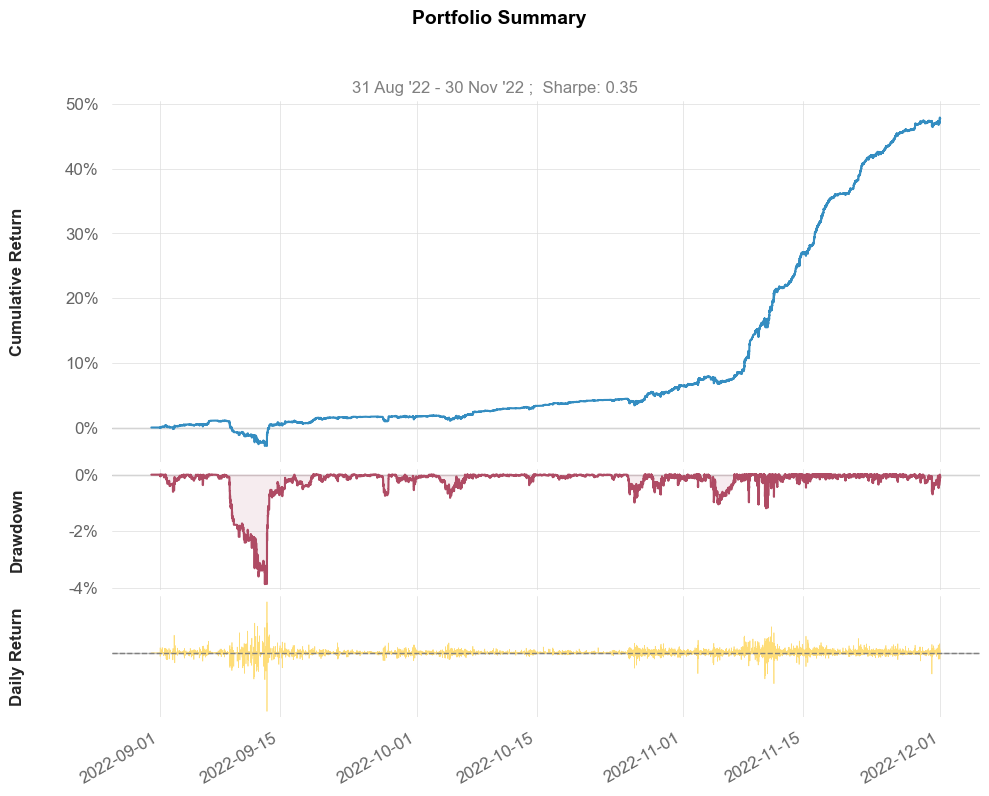

In [86]:
qs.plots.snapshot(df_merge['total_value_eth'])

In [87]:


filename = f"{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha}_{period_n}.html"
# df_merge['total_value'].plot_snapshot()
qs.reports.html(df_merge['total_value_eth'],benchmark=df_merge['net_value_eth'],mode='full',periods_per_year=365, download_filename=f"./reports/{filename}",output='report')


# A2 test

In [88]:
df_merge['total_value_eth'].sharpe()

0.35270401714660476

In [89]:
a = 1.20
hedge_spread_split = 2.5
hedge_spread_rate = 0.86
alpha = 0.037
ema_max_spread_rate=0.2
period_n2 = 9

instance2=backtest_boll(a=a,hedge_spread_split=hedge_spread_split,hedge_spread_rate=hedge_spread_rate,alpha=alpha,boll_period_n=period_n2)

df_merge2 = generate_dfmerge(instance2)

# fig = df_merge[['price_rate','total_value_eth_profit_rate','total_value_profit_rate']].plot().get_figure()

# fig.savefig('./fig/test.pdf')

# plot2 = df_merge2[['price_rate','total_value_eth_profit_rate','net_value_rate','total_value_profit_rate']].plot()

# plot2.write_image(f"./fig/{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha}_{period_n2}.png")

# plot2.show()
filename = f"{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha}_{period_n2}.html"
# df_merge['total_value'].plot_snapshot()
qs.reports.html(df_merge2['total_value_eth'],benchmark=df_merge2['net_value_eth'],mode='full',periods_per_year=365, download_filename=f"./reports/{filename}",output='report')

2022-12-19 01:01:45,694 - INFO - start load files from 2022-09-01 to 2022-11-30...


init parameters: a:1.20, hedge_spread_split:2.5, hedge_spread_rate:0.86,alpa:0.037,period_n:9



2022-12-19 01:01:48,654 - INFO - load file complete, preparing...
2022-12-19 01:01:56,205 - INFO - data has benn prepared
2022-12-19 01:01:56,207 - INFO - init strategy...


add ema column with alpha 0.037
130976


2022-12-19 01:01:58,104 - INFO - start main loop...


hedge rebalance ETH -24.80777935392767014527344056 20124.73558706320389991576924 profit: 0E-49
after rebalance=> lp total symbol:49.61555870785534029054688112, future amount:24.80777935392767014527344056, status:AccountStatus(timestamp=None, base_balance=Decimal('498500.0000000000000000000001'), quote_balance=Decimal('24.84504692431414135730940466'), base_uncollected=Decimal('0'), quote_uncollected=Decimal('0'), base_in_position=Decimal('0'), quote_in_position=Decimal('0'), net_value=Decimal('998500.0000000000000000000000'), price=Decimal('20124.73558706320389991576924'))
prepare to add LP: rate:1.20 price:20124.73558706320389991576924 down:16770.61298921933658326314103 up:24149.68270447584467989892309 init symbol amount:59.62811261835393980921343405,init usdc amount:1200000.000000000011102230246
eth_value 0.08750596819272489767571750 usdc value 0


 76%|████████████████████████████████████████████████████████████████████████████████▏                         | 99020/130976 [18:59<09:16, 57.38it/s]

2022-11-08 19:13:00 hedge lower sell ETH,c_amount:34.73751514876452559634241898,f_amount:24.80777935392767014527344056, upper:21866.21,middle:20902.65,lower,19939.09, trade price: 18514.49343733963877522822754,ema:18782.41576796065,trade amount: 8.516594088905767262113988349, hedge count:1


 76%|████████████████████████████████████████████████████████████████████████████████▊                         | 99926/130976 [19:12<07:08, 72.47it/s]

2022-11-09 10:15:00 hedge lower sell ETH,c_amount:43.28370893546467913626462952,f_amount:16.29118526502190288315945221, upper:22725.15,middle:20889.79,lower,19054.43, trade price: 17218.03677650906547665565829,ema:17736.87870009171,trade amount: 8.516594088905767262113988349, hedge count:2


 77%|████████████████████████████████████████████████████████████████████████████████▌                        | 100419/130976 [19:19<06:30, 78.29it/s]

2022-11-09 18:42:00 hedge lower sell ETH,c_amount:51.76666455330097433450656516,f_amount:7.774591176116135621045463861, upper:22725.15,middle:20889.79,lower,19054.43, trade price: 16582.68973182262723122608433,ema:16783.092066007284,trade amount: 8.516594088905767262113988349, hedge count:3
2022-11-09 18:44:00  => last hedge sell ETH,price: 16508.23899030218579883673468,c_amount:51.89321764369758462938176507,f_amount:-0.742002912789631641068524488,ema:16765.781966636863, trade amoutn: 1.535656023052612697766359462, hedge count:4
2022-11-09 18:44:00 out of range, price:16508.23899030218579883673468,ema:16765.781966636863 symbol:51.89321764369758462938176507, usdc:0
hedge rebalance ETH -32.98013002618515576783893545 16508.23899030218579883673468 profit: -65951.66846672203303054114011
after rebalance=> lp total symbol:61.40494218068582285800810301, future amount:30.70247109034291142900405150, status:AccountStatus(timestamp=None, base_balance=Decimal('506210.5808675613339079672827'), quote

 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 101658/130976 [19:36<05:43, 85.26it/s]

2022-11-10 15:10:00 hedge mid buy ETH,c_amount:20.69706025700455884633576194,f_amount:30.70247109034291142900405150, upper:23977.50,middle:20671.25,lower:,17365.00, trade price:17802.80117464143726549109693,ema:17483.282849614883, trade amount:8.516594088905767262113988349, hedge count:5


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 116454/130976 [26:19<08:14, 29.35it/s]

2022-11-20 21:52:00 hedge mid sell ETH,c_amount:32.10196846944037220653468397,f_amount:39.21906517924867869111803985, upper:16546.99,middle:16271.32,lower:,15995.66, trade price: 16259.22351991028313186070776,ema:16372.635074373029,trade amount: 8.516594088905767262113988349, hedge count:6


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 117924/130976 [26:59<05:57, 36.47it/s]

2022-11-21 22:19:00 hedge lower sell ETH,c_amount:40.62121674326611011360538718,f_amount:30.70247109034291142900405150, upper:16614.01,middle:16122.97,lower,15631.93, trade price: 15526.72377438903279776976006,ema:15610.63267876558,trade amount: 8.516594088905767262113988349, hedge count:7


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████        | 121030/130976 [28:49<03:19, 49.79it/s]

2022-11-24 02:07:00 hedge up buy ETH, c_amount:29.29811245462589367178999308,f_amount:22.18587700143714416689006315,upper:16511.76,middle:15894.97,lower:,15278.17, trade price:16739.29407254600912475831375,ema:16635.660694075556, trade amount:8.516594088905767262113988349, hedge count:8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 130976/130976 [33:26<00:00, 65.28it/s]
2022-12-19 01:35:24,572 - INFO - main loop finished, start calculate evaluating indicator...
2022-12-19 01:35:26,359 - INFO - run evaluating indicator
2022-12-19 01:35:26,651 - INFO - back testing finish


ema+alpha:1 times, a:1.20, hedge_spread_split:2.5, hedge_spread_rate:0.86,alpa:0.037
 result: outside_ema_count:0,hedge count:8 final_total_eth_value:87.934,final_total_usdc_value:1510727.064
USDC profit: 310727.064, profit_rate: 0.259
ETH profit: 28.306, profit_rate: 0.475


In [ ]:
qs.reports.html(df_merge2['total_value_eth'],benchmark=df_merge2['net_value_eth'],mode='full',periods_per_year=365, download_filename=f"./reports/{filename}",output='report')

# a3 ema hedge

In [90]:
a = 1.20
hedge_spread_split = 2.5
hedge_spread_rate = 0.86
alpha3 = 0.037
ema_max_spread_rate2=0.2

instance3=backtest_instance(a,hedge_spread_split,hedge_spread_rate,alpha3)

df_merge3 = generate_dfmerge(instance3)

filename = f"{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha}.html"
# df_merge['total_value'].plot_snapshot()
qs.reports.html(df_merge['total_value'],benchmark=df_merge['price'],mode='full',periods_per_year=365, download_filename=f"./reports/{filename}",output='report')

# plot3 = df_merge3[['price_rate','total_value_eth_profit_rate','net_value_rate','total_value_profit_rate']].plot()

# plot3.write_image(f"./fig/{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha3}.png")

# plot3.show()
filename = f"{NET_VALUE_BASE}_{DATE_START}_{DATE_END}_{a}_{hedge_spread_split}_{hedge_spread_rate}_{alpha3}.html"
# df_merge['total_value'].plot_snapshot()
qs.reports.html(df_merge3['total_value_eth'],benchmark=df_merge3['net_value_eth'],mode='full',periods_per_year=365, download_filename=f"./reports/{filename}",output='report')

2022-12-19 01:36:33,127 - INFO - start load files from 2022-09-01 to 2022-11-30...


init parameters: a:1.20, hedge_spread_split:2.5, hedge_spread_rate:0.86,alpa:0.037,period_n:1440



FileNotFoundError: [Errno 2] No such file or directory: '../demeter/data/ETH/0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640/Ethereum-0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-2022-11-14.csv'